# Scaling Arguments
This notebook makes all plots related to the scaling arguments in Wenegrat 2023 CFB on EBF manuscript.


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import xarray as xr
import xgcm
from glob import glob
from dask.diagnostics import ProgressBar
import sys
import matplotlib.patches as patches
import matplotlib.ticker as tck

sys.path.append('/homes/metofac/wenegrat/xroms/')
sys.path.append('/homes/metofac/wenegrat/pyspec/')

#from xroms import open_roms_netcdf_dataset
import xroms
from pyspec import spectrum as spec
from scipy import integrate as integrate
from timeit import default_timer as timer
#%%
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 28
plt.rcParams['contour.negative_linestyle'] = 'solid'

import sys
sys.path.append("../src/")
import load_model_runs as lruns

from importlib import reload  

import cmocean.cm as cmo

In [2]:
## LOAD THE SIMULATION (ONLY NEED WC HERE)
reload(lruns)
#dsWC, gridWC = lruns.loadRun('../data/model/JET_ML_CFB/', chunks={'time':1}, old=False, avg=False)
dsWC, gridWC = lruns.newLoad('../data/model/JET_NML_CFB_BFLUX/', chunks={'time':1})
dsWC
# reload(lruns)
# # dsNC, gridNC = lruns.loadRun('../data/model/JET_ML_NOCFB/', chunks={'time':1}, old=False, avg=False)
# dsNC, grid = lruns.newLoad('../data/model/JET_NML_NOCFB_BFLUX/', chunks={'time':1})

<xarray.Dataset>
Dimensions:     (xi_rho: 1002, xi_u: 1001, eta_rho: 4002, eta_v: 4001,
                 s_rho: 100, s_w: 101, ocean_time: 46, auxil: 4)
Coordinates: (12/26)
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000 1001
  * xi_u        (xi_u) int64 0 1 2 3 4 5 6 7 ... 994 995 996 997 998 999 1000
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 ... 3996 3997 3998 3999 4000 4001
  * eta_v       (eta_v) int64 0 1 2 3 4 5 6 ... 3995 3996 3997 3998 3999 4000
  * s_rho       (s_rho) float64 -0.995 -0.985 -0.975 ... -0.025 -0.015 -0.005
  * s_w         (s_w) float32 -1.0 -0.99 -0.98 -0.97 ... -0.03 -0.02 -0.01 0.0
    ...          ...
    z_rho_v0    (s_rho, eta_v, xi_rho) float64 dask.array<chunksize=(100, 4001, 1002), meta=np.ndarray>
    z_rho_psi0  (s_rho, eta_v, xi_u) float64 dask.array<chunksize=(100, 4001, 1001), meta=np.ndarray>
    z_w0        (s_w, eta_rho, xi_rho) float32 dask.array<chunksize=(101, 4002, 1002), meta=np.ndarray>
    z_w_u0      (s_w, eta_rho, xi_u) float32 dask.array<chunksize=(101, 4002, 1001), meta=np.ndarray>
    z_w_v0      (s_w, eta_v, xi_rho) float32 dask.array<chunksize=(101, 4001, 1002), meta=np.ndarray>
    z_w_psi0    (s_w, eta_v, xi_u) float32 dask.array<chunksize=(101, 4001, 1001), meta=np.ndarray>
Dimensions without coordinates: auxil
Data variables: (12/68)
    spherical   int64 0
    xl          float32 ...
    el          float32 ...
    Vtransform  float32 ...
    sc_r        (s_rho) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    sc_w        (s_w) float32 dask.array<chunksize=(101,), meta=np.ndarray>
    ...          ...
    dV_v        (ocean_time, s_rho, eta_v, xi_rho) float32 dask.array<chunksize=(1, 100, 4001, 1002), meta=np.ndarray>
    dV_w_v      (ocean_time, s_w, eta_v, xi_rho) float64 dask.array<chunksize=(1, 101, 4001, 1002), meta=np.ndarray>
    dV_psi      (ocean_time, s_rho, eta_v, xi_u) float32 dask.array<chunksize=(1, 100, 4001, 1001), meta=np.ndarray>
    dV_w_psi    (ocean_time, s_w, eta_v, xi_u) float64 dask.array<chunksize=(1, 101, 4001, 1001), meta=np.ndarray>
    rho0        int64 1025
    rho         (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 100, 4002, 1002), meta=np.ndarray>
Attributes: (12/55)
    type:          ROMS history file
    title:         JET Example (use make_jet.m for non ANA_JET config)
    date:          
    rst_file:      jet_rst.nc
    his_file:      jet_his.00000.nc
    avg_file:      jet_avg.nc
    ...            ...
    Scoef_expl:    Saline contraction coefficient
    Scoef_units:   kg.m-3.psu-1
    gamma2:        1.0
    gamma2_expl:   Slipperiness parameter
    SRCS:          main.F step.F read_inp.F timers_roms.F init_scalars.F init...
    CPP-options:   JET MPI NC4PAR SOLVE3D UV_COR UV_ADV UV_HADV_UP3 UV_VIS2 U...

## CALCULATE VARIABLES

In [3]:
# Define time and y limits
TR = slice(5, 30)
YL = slice(700*2, 1300*2)
YL = slice(1000, 3002)

In [4]:
#tau prime vs theory.
TMag = np.sqrt(2*5**2)
txp = dsWC.sustr.isel(ocean_time=TR) - 1e-3*np.sqrt(5**2*2)*5#dsWC.sustr.isel(ocean_time=TS).mean(('xi_u', 'eta_rho'))
txptheory = -3/2*1e-3*TMag*dsWC.u.isel(s_rho=-1, ocean_time=TR)
typ = dsWC.svstr.isel(ocean_time=TR) - 1e-3*np.sqrt(5**2*2)*5#dsWC.sustr.isel(ocean_time=TS).mean(('xi_u', 'eta_rho'))
typtheory = -3/2*1e-3*TMag*dsWC.v.isel(s_rho=-1, ocean_time=TR)
tp = np.concatenate((txp.isel(eta_rho=YL).values.flatten(), typ.isel(eta_v=YL).values.flatten()))
tptheory = np.concatenate((txptheory.isel(eta_rho=YL).values.flatten(), typtheory.isel(eta_v=YL).values.flatten()))

In [5]:
#EBF prime vs EBF theory
bx = xroms.to_rho(-9.8/1020*gridWC.derivative(dsWC.rho.isel(s_rho=-1), 'X'), gridWC)
by = xroms.to_rho(-9.8/1020*gridWC.derivative(dsWC.rho.isel(s_rho=-1), 'Y'), gridWC)
dsWC['bx'] = bx
dsWC['by'] = by
dsWC['Nablab'] = np.sqrt(bx**2 + by**2)

# Direct calculation of EBF prime
dsWC['EBF'] = (bx*xroms.to_rho(dsWC.svstr, gridWC) - by*xroms.to_rho(dsWC.sustr, gridWC))/(dsWC.f*1020)
dsWC['EBFm'] = (bx*1e-3*7*5 - by*1e-3*7*5)/(dsWC.f*1020)
dsWC['EBFp'] = dsWC.EBF - dsWC.EBFm
EBFpp = (bx.isel(ocean_time=TR)*xroms.to_rho(typtheory, gridWC) - by.isel(ocean_time=TR)*xroms.to_rho(txptheory, gridWC))/(dsWC.f*1020)

# Theoretical scaling for EBF prime
dsWC['uo'] = xroms.to_rho(dsWC.u.isel(s_rho=-1), gridWC)
uo = dsWC.uo
dsWC['vo'] = xroms.to_rho(dsWC.v.isel(s_rho=-1), gridWC)
vo = dsWC.vo
dsWC['usurfmag'] = (dsWC.uo**2 + dsWC.vo**2)**(1/2)
dsWC['EBFpt'] = -1e-3*3/(1020*dsWC.f*2)*7*dsWC.usurfmag*dsWC.Nablab

In [6]:
(bx.isel(ocean_time=TR)*xroms.to_rho(typ, gridWC) - by.isel(ocean_time=TR)*xroms.to_rho(txp, gridWC))

<xarray.DataArray (ocean_time: 25, eta_rho: 4002, xi_rho: 1002)>
dask.array<sub, shape=(25, 4002, 1002), dtype=float32, chunksize=(1, 4002, 1002), chunktype=numpy.ndarray>
Coordinates:
  * xi_rho   (xi_rho) int64 0 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000 1001
  * eta_rho  (eta_rho) int64 0 1 2 3 4 5 6 ... 3996 3997 3998 3999 4000 4001
Dimensions without coordinates: ocean_time

In [7]:
# u_o vs. u_g, y_o vs y_g
dsWC['ug'] = -dsWC.by*dsWC.hbl/dsWC.f
dsWC['vg'] =  dsWC.bx*dsWC.hbl/dsWC.f

dsWC['ug_o'] = -9.8*xroms.to_rho(gridWC.derivative(dsWC.zeta, 'Y'), gridWC)/dsWC.f
dsWC['vg_o'] =  9.8*xroms.to_rho(gridWC.derivative(dsWC.zeta, 'X'), gridWC)/dsWC.f

dsWC['ug_mag'] = np.sqrt(dsWC.ug**2 + dsWC.vg**2)
dsWC['uo_mag'] = np.sqrt(dsWC.uo**2 + dsWC.vo**2)

## PLOTS

In [29]:
def histoPlot(xvals, yvals, xedges, yedges, ax):
    denominator, _, _ = np.histogram2d(xvals, yvals ,bins=(xedges, yedges), density=False)
    denominator = denominator/np.sum(denominator)
#     denominator = denominator/np.max(denominator)
    denominator = denominator.T #need to transpose to have the correct orientation.
    ix = ax.pcolor(xedges, yedges, np.log10(denominator), vmin = -5, vmax=-2, cmap='inferno')
    ix.set_edgecolors('face')
    ax.axis('square')
    ax.plot(xedges, xedges, color='w')
    ax.grid()
    ax.set_facecolor('k')
    return ix

In [42]:
# Statistics
# tau_error = (tptheory/tp - 1)
tau_error = (tptheory - tp)/tp
# tau_error = tau_error[np.isfinite(tau_error)]
tau_error = tau_error[np.abs(tp/(1e-3*TMag*5))>0.25]
RMSP_Tau = np.sqrt((tau_error**2).mean())
print(RMSP_Tau)

ebftheory =  EBFpp.isel(eta_rho=YL).transpose('ocean_time',...).values.flatten()
ebfreal = dsWC.EBFp.isel(ocean_time=TR, eta_rho=YL).values.flatten()
ebf_error = (ebftheory - ebfreal)/ebfreal
# ebf_error = tau_error[np.isfinite(tau_error)]
ebf_error = ebf_error[np.abs(ebfreal)>1e-7]
RMSP_Tau = np.sqrt((ebf_error**2).mean())
print(RMSP_Tau)

/tmp/ipykernel_3343661/1303725698.py:3: RuntimeWarning: divide by zero encountered in divide
  tau_error = (tptheory - tp)/tp


0.13425031
0.24090798


/tmp/ipykernel_3343661/1303725698.py:11: RuntimeWarning: divide by zero encountered in divide
  ebf_error = (ebftheory - ebfreal)/ebfreal
/tmp/ipykernel_3343661/1303725698.py:11: RuntimeWarning: invalid value encountered in divide
  ebf_error = (ebftheory - ebfreal)/ebfreal


0.5190548


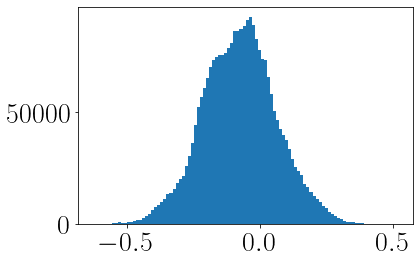

In [37]:
plt.hist(tau_error, 100)
# plt.yscale('log')
print(np.max(tau_error))

### Plot 2d histograms

1) t' vs t'_theory
2) EBF' vs. EBF'_theory
3) Scaling of u_o vs. u_g in magnitude and direction (alignment to gradb most important).

/tmp/ipykernel_3343661/851602526.py:6: RuntimeWarning: divide by zero encountered in log10
  ix = ax.pcolor(xedges, yedges, np.log10(denominator), vmin = -5, vmax=-2, cmap='inferno')


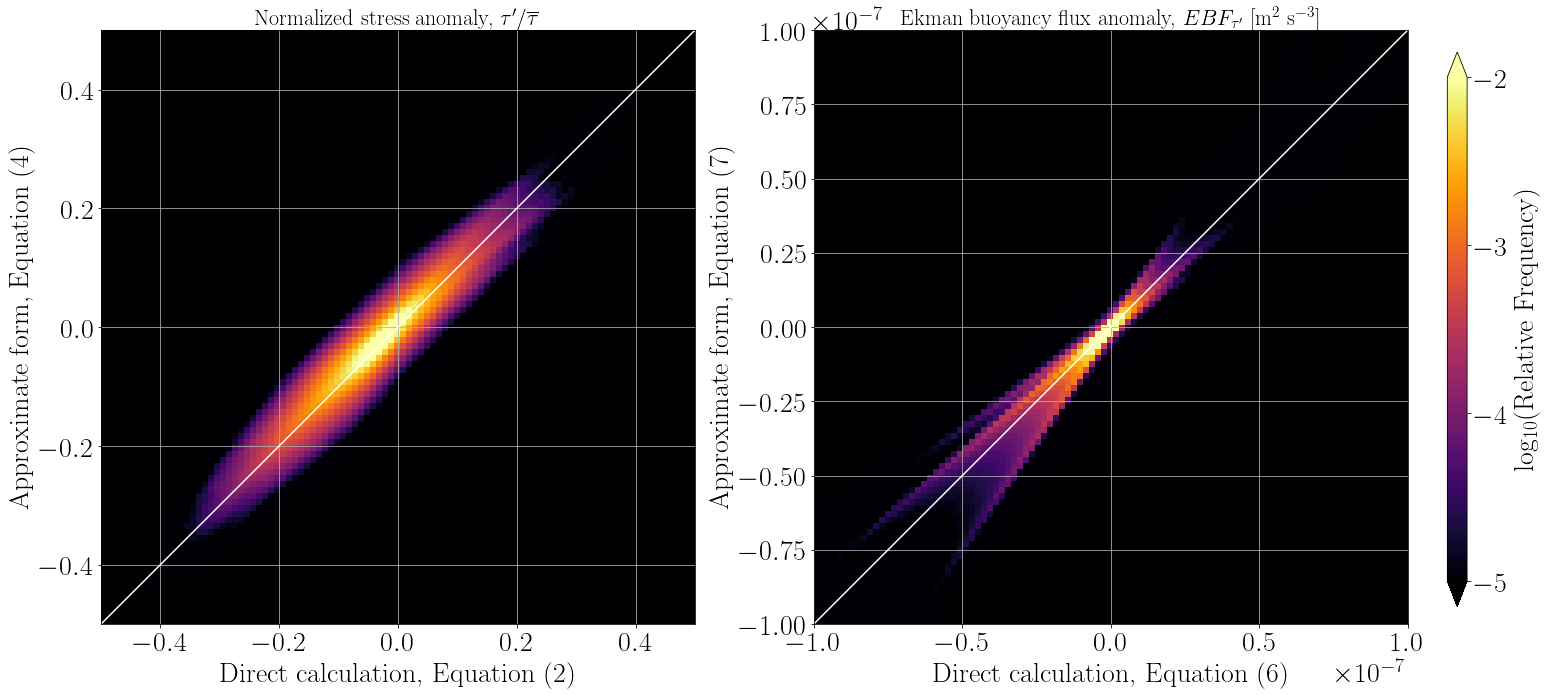

In [30]:
fig, ax = plt.subplots(1,2,figsize=(22, 11), sharey=False)
xedges = np.linspace(-0.5, 0.5, 100)
# xedges = np.linspace(-0.4, 0.4, 100)
#tau' vs tau'_theory
histoPlot(tp/(1e-3*TMag*5), tptheory/(1e-3*TMag*5), xedges, xedges, ax[0])
ax[0].set_xlabel(r'CFB stress anomaly, ${\tau^\prime}/|\overline{\mathbf{\tau}}|$')
ax[0].set_xlabel(r'Direct calculation, Equation (2)')
#ax[0].set_ylabel(r'Approximate CFB stress,\\ $-(3/2)\rho_a c_d |U_a|u_o/|\overline{\mathbf{\tau}}|$')
ax[0].set_ylabel(r'Approximate form, Equation (4)')
ax[0].set_title(r'Normalized stress anomaly, $\tau^\prime/\overline{\tau}$', fontsize=22)
#EBF' vs EBF'_theory
xedges = np.linspace(-3e-7, 1e-7, 100)
xedges = np.linspace(-4e-7, 2e-7, 100)
xedges = np.linspace(-1e-7, 1e-7, 100)
# ix = histoPlot(dsWC.EBFp.isel(ocean_time=TR, eta_rho=YL).values.flatten(), dsWC.EBFpt.isel(ocean_time=TR, eta_rho=YL).transpose('ocean_time',...).values.flatten(), xedges, xedges, ax[1])
ix = histoPlot(dsWC.EBFp.isel(ocean_time=TR, eta_rho=YL).values.flatten(), EBFpp.isel(eta_rho=YL).transpose('ocean_time',...).values.flatten(), xedges, xedges, ax[1])

#ax[1].set_xlabel(r'Full $EBF_{\tau^\prime}$, ${\tau^\prime}/|\overline{\mathbf{\tau}}|$')
#ax[1].set_ylabel(r'Approximate $EBF_{\tau^\prime}$, $-(3/2)\rho_a c_d |U_a|u_o|/\overline{\mathbf{\tau}}|$')
ax[1].set_xlabel(r'Direct calculation, Equation (6)')
ax[1].set_ylabel(r'Approximate form, Equation (7)')
ax[1].set_title(r'Ekman buoyancy flux anomaly, $EBF_{\tau^\prime}$ [m$^2$ s$^{-3}$]', fontsize=22)
# ax[1].set_yticks([-3e-7, -2e-7, -1e-7, 0, 1e-7])
# Add Colorbar
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.975, 0.15, 0.0125, 0.7])
cb = fig.colorbar(ix, cax=cbar_ax, extend='both')
cb.set_label('log$_{10}$(Relative Frequency)')
cb.set_ticks([-5, -4, -3, -2])
cb.solids.set_edgecolor("face") 

# plt.savefig('../figures/ScalingComparisons.pdf', bbox_inches='tight')

/tmp/ipykernel_3343661/2271305391.py:5: RuntimeWarning: divide by zero encountered in log10
  ix = ax.pcolor(xedges, yedges, np.log10(denominator), vmin = -5, vmax=-2, cmap='inferno')
/tmp/ipykernel_3343661/2271305391.py:5: RuntimeWarning: divide by zero encountered in log10
  ix = ax.pcolor(xedges, yedges, np.log10(denominator), vmin = -5, vmax=-2, cmap='inferno')


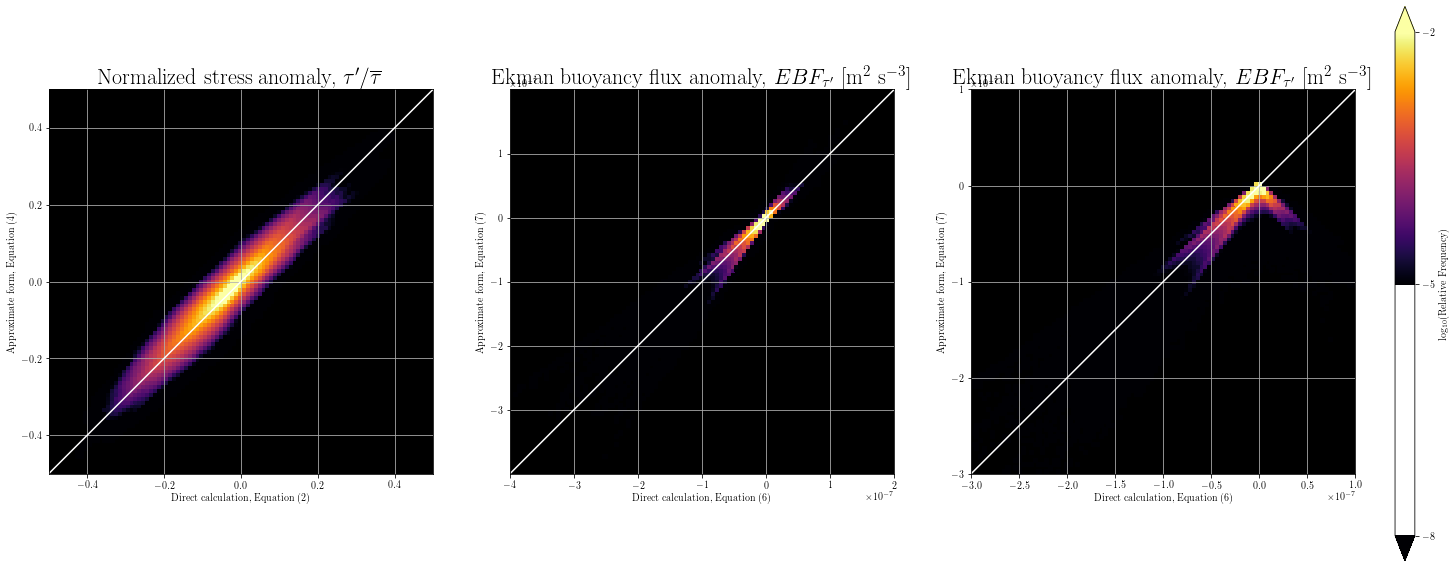

In [10]:
fig, ax = plt.subplots(1,3,figsize=(22, 11), sharey=False)
xedges = np.linspace(-0.5, 0.5, 100)

#tau' vs tau'_theory
histoPlot(tp/(1e-3*TMag*5), tptheory/(1e-3*TMag*5), xedges, xedges, ax[0])
ax[0].set_xlabel(r'CFB stress anomaly, ${\tau^\prime}/|\overline{\mathbf{\tau}}|$')
ax[0].set_xlabel(r'Direct calculation, Equation (2)')
#ax[0].set_ylabel(r'Approximate CFB stress,\\ $-(3/2)\rho_a c_d |U_a|u_o/|\overline{\mathbf{\tau}}|$')
ax[0].set_ylabel(r'Approximate form, Equation (4)')
ax[0].set_title(r'Normalized stress anomaly, $\tau^\prime/\overline{\tau}$', fontsize=22)
#EBF' vs EBF'_theory
xedges = np.linspace(-3e-7, 1e-7, 100)
xedges = np.linspace(-4e-7, 2e-7, 100)

# Accurate version
# ix = histoPlot(dsWC.EBFp.isel(ocean_time=TR, eta_rho=YL).values.flatten(), dsWC.EBFpt.isel(ocean_time=TR, eta_rho=YL).transpose('ocean_time',...).values.flatten(), xedges, xedges, ax[1])
ix = histoPlot(dsWC.EBFp.isel(ocean_time=TR, eta_rho=YL).values.flatten(), EBFpp.isel(eta_rho=YL).transpose('ocean_time',...).values.flatten(), xedges, xedges, ax[1])

#ax[1].set_xlabel(r'Full $EBF_{\tau^\prime}$, ${\tau^\prime}/|\overline{\mathbf{\tau}}|$')
#ax[1].set_ylabel(r'Approximate $EBF_{\tau^\prime}$, $-(3/2)\rho_a c_d |U_a|u_o|/\overline{\mathbf{\tau}}|$')
ax[1].set_xlabel(r'Direct calculation, Equation (6)')
ax[1].set_ylabel(r'Approximate form, Equation (7)')
ax[1].set_title(r'Ekman buoyancy flux anomaly, $EBF_{\tau^\prime}$ [m$^2$ s$^{-3}$]', fontsize=22)
ax[1].set_yticks([-3e-7, -2e-7, -1e-7, 0, 1e-7])

# Approximate version
xedges = np.linspace(-3e-7, 1e-7, 100)

ix = histoPlot(dsWC.EBFp.isel(ocean_time=TR, eta_rho=YL).values.flatten(), dsWC.EBFpt.isel(ocean_time=TR, eta_rho=YL).transpose('ocean_time',...).values.flatten(), xedges, xedges, ax[2])

ax[2].set_xlabel(r'Direct calculation, Equation (6)')
ax[2].set_ylabel(r'Approximate form, Equation (7)')
ax[2].set_title(r'Ekman buoyancy flux anomaly, $EBF_{\tau^\prime}$ [m$^2$ s$^{-3}$]', fontsize=22)
ax[2].set_yticks([-3e-7, -2e-7, -1e-7, 0, 1e-7])
# Add Colorbar
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.975, 0.15, 0.0125, 0.7])
cb = fig.colorbar(ix, cax=cbar_ax, extend='both')
cb.set_label('log$_{10}$(Relative Frequency)')
cb.set_ticks([-8, -5, -2])
cb.solids.set_edgecolor("face") 

# plt.savefig('../figures/ScalingComparisons.pdf', bbox_inches='tight')

In [206]:
### FIGURE OUT HOW SIGNFIICANT THE POSITIVE REGIONS OF EBF' are
###############################################################

ebfp = dsWC.EBFp.isel(ocean_time=TR, eta_rho=YL)
ebf  = dsWC.EBF.isel(ocean_time=TR, eta_rho=YL)

# What is the raw percentage that are positive?
print(f'Raw percentage >0? {ebfp.where(ebfp>0).count().values/ebfp.count().values}')

# What is the weighted percentage
print(f'Percent average >0? {ebfp.where(ebfp>0).sum().values/ebfp.sum().values}')

# What is the weighted percentage
print(f'Percent average >0? {ebfp.where(ebfp>0).sum().values/ebfp.where(ebfp<=0).sum().values}')

print(f'Maximum EBF? {btowatts*ebf.max().values}')

print(f'Minimum EBF? {btowatts*ebf.min().values}')

Raw percentage >0? 0.32275399251447157
Percent average >0? -0.21584199368953705
Percent average >0? -0.17752474546432495
Maximum EBF? 3148.941821527099
Minimum EBF? -5202.1863740840345


/tmp/ipykernel_77339/1466373555.py:5: RuntimeWarning: divide by zero encountered in log10
  ix = ax.pcolor(xedges, yedges, np.log10(denominator), vmin = -8, vmax=-2, cmap='inferno')
/tmp/ipykernel_77339/1466373555.py:5: RuntimeWarning: divide by zero encountered in log10
  ix = ax.pcolor(xedges, yedges, np.log10(denominator), vmin = -8, vmax=-2, cmap='inferno')


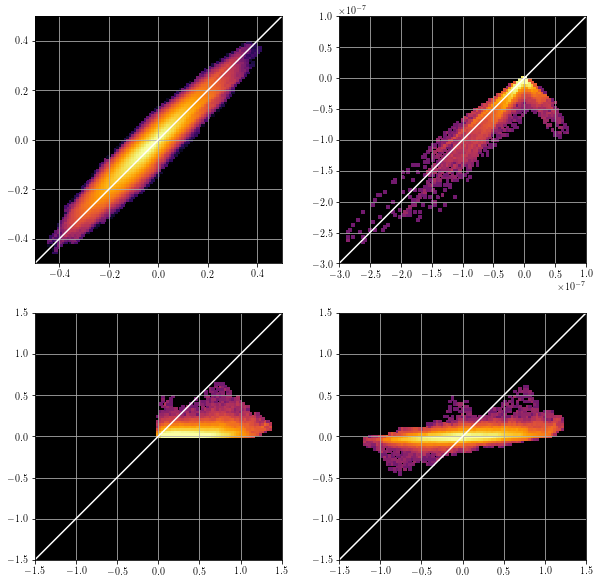

In [95]:
fig, ax = plt.subplots(2,2,figsize=(10, 10), sharey=False)
xedges = np.linspace(-0.5, 0.5, 100)

#tau' vs tau'_theory
histoPlot(tp/(1e-3*TMag*5), tptheory/(1e-3*TMag*5), xedges, xedges, ax[0, 0])

#EBF' vs EBF'_theory
xedges = np.linspace(-3e-7, 1e-7, 100)
histoPlot(dsWC.EBFp.isel(ocean_time=TR, eta_rho=YL).values.flatten(), dsWC.EBFpt.isel(ocean_time=TR, eta_rho=YL).values.flatten(), xedges, xedges, ax[0, 1])

#u,v obs vs geo
xedges = np.linspace(-1.5, 1.5, 100)
uo = dsWC.uo.where(dsWC.Nablab>1e-6, drop=True).isel(ocean_time=TR, eta_rho=YL)
ug = dsWC.ug.where(dsWC.Nablab>1e-6, drop=True).isel(ocean_time=TR, eta_rho=YL)
#histoPlot(uo.values.flatten(), ug.values.flatten(), xedges, xedges, ax[1,0])
umag = dsWC.uo_mag.where(dsWC.Nablab>1e-8, drop=True).isel(ocean_time=TR, eta_rho=YL)
ugmag = dsWC.ug_mag.where(dsWC.Nablab>1e-8, drop=True).isel(ocean_time=TR, eta_rho=YL)
histoPlot(umag.values.flatten(), ugmag.values.flatten(), xedges, xedges, ax[1,0])

histoPlot(dsWC.vo.isel(ocean_time=TR, eta_rho=YL).values.flatten(), dsWC.vg.isel(ocean_time=TR, eta_rho=YL).values.flatten(), xedges, xedges, ax[1,1])

<AxesSubplot:>

/tmp/ipykernel_77339/4168833294.py:23: RuntimeWarning: divide by zero encountered in log10
  ix = ax[0].pcolor(xedges, yedges, np.log10(denominator), vmin = -8, vmax=-2, cmap='inferno')


NameError: name 'ug' is not defined

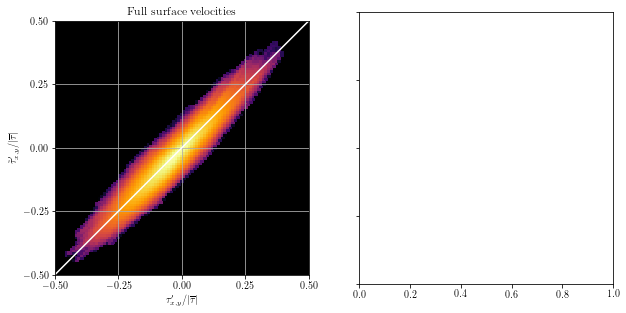

In [4]:


tp = tp/(1e-3*TMag*5)
tptheory=tptheory/(1e-3*TMag*5)

xedges = np.linspace(-0.5, 0.5, 100)
yedges = xedges
#denominator, _, _ = np.histogram2d(txp.values.flatten(),txptheory.values.flatten(),bins=(xedges, yedges))
denominator, _, _ = np.histogram2d(tp, tptheory,bins=(xedges, yedges))
denominator = denominator/np.sum(denominator)

fig, ax = plt.subplots(1,2,figsize=(10, 5), sharey=True)

ix = ax[0].pcolor(xedges, yedges, np.log10(denominator), vmin = -8, vmax=-2, cmap='inferno')
ix.set_edgecolors('face')
ax[0].axis('square')
ax[0].plot(xedges, xedges, color='w')
ax[0].grid()
ax[0].set_facecolor('k')
ax[0].set_xlabel(r'$\tau^\prime_{x,y}/|\overline{\mathbf{\tau}}|$')
ax[0].set_ylabel(r'$\tilde{\tau}^\prime_{x,y}/|\overline{\mathbf{\tau}}|$')
ax[0].set_title('Full surface velocities')
ax[0].set_xticks([-0.5, -0.25, 0, 0.25, 0.5])
ax[0].set_yticks([-0.5, -0.25, 0, 0.25, 0.5])

txptheory_ug = -3/2*1e-3*TMag*ug.isel(ocean_time=TR, eta_rho=YL)
typtheory_vg = -3/2*1e-3*TMag*vg.isel(ocean_time=TR, eta_v=YL)

tptheory_geo = np.concatenate((txptheory_ug.values.flatten(), typtheory_vg.values.flatten()))

tptheory_geo = tptheory_geo/(1e-3*TMag*5)

denominator, _, _ = np.histogram2d(tp, tptheory_geo,bins=(xedges, yedges), density=False)
denominator = denominator/np.sum(denominator)
ix = ax[1].pcolor(xedges, yedges, np.log10(denominator), vmin = -8, vmax=-2, cmap='inferno')
ix.set_edgecolors('face')
ax[1].axis('square')
ax[1].plot(xedges, xedges, color='w')
ax[1].grid()
ax[1].set_facecolor('k')
ax[1].set_xlabel(r'$\tau^\prime_{x,y}/|\overline{\mathbf{\tau}}|$')
#ax[1].set_ylabel(r'$\tilde{\tau}^\prime_{x,y}/|\overline{\mathbf{\tau}}|$')
ax[1].set_title('Geostrophic surface velocities')
ax[1].set_xticks([-0.5, -0.25, 0, 0.25, 0.5])
ax[1].set_yticks([-0.5, -0.25, 0, 0.25, 0.5])

# Add Colorbar
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.975, 0.15, 0.0125, 0.7])
cb = fig.colorbar(ix, cax=cbar_ax, extend='both')
cb.set_label('log$_{10}$(Relative Frequency)')
cb.set_ticks([-8, -5, -2])
cb.solids.set_edgecolor("face") 

#plt.savefig('../figures/ScalingComparisons.pdf', bbox_inches='tight')

### QUICK AND DIRTY CHECKS

/tmp/ipykernel_77339/1466373555.py:5: RuntimeWarning: divide by zero encountered in log10
  ix = ax.pcolor(xedges, yedges, np.log10(denominator), vmin = -8, vmax=-2, cmap='inferno')


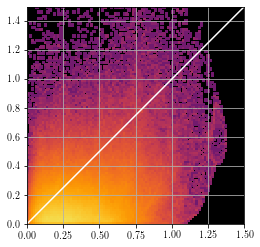

In [79]:
fig, ax = plt.subplots(1,1)
#ax.scatter(dsWC.uo.isel(ocean_time=TR).values.flatten(), dsWC.ug.isel(ocean_time=TR).values.flatten())
xedge = np.linspace(0, 1.5, 100)
histoPlot(dsWC.uo_mag.isel(ocean_time=TR, eta_rho=YL).values.flatten(), 5*dsWC.ug_mag.isel(ocean_time=TR, eta_rho=YL).values.flatten(), xedge, xedge, ax)

/tmp/ipykernel_78361/2317409757.py:5: RuntimeWarning: divide by zero encountered in log10
  ix = ax.pcolor(xedges, yedges, np.log10(denominator), vmin = -8, vmax=-2, cmap='inferno')


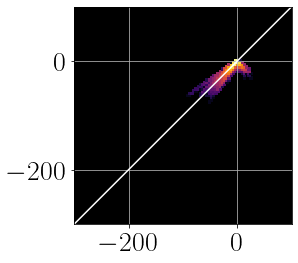

In [151]:
### CONFIRM WHY THERE ARE POSITIVE VALUES OF EBF_tau'

# Possibilites are: sign errors in tau' approximation, opposing u_o and surf geo shear.

xvar = dsWC.EBFp.isel(ocean_time=TR, eta_rho=YL)
yvar = dsWC.EBFpt.isel(ocean_time=TR, eta_rho=YL).transpose('ocean_time',...)
xedge = np.linspace(-3e-7, 1e-7, 100)


norm = dsWC.EBFm.isel(ocean_time=30, eta_rho=YL).mean()
xvar = xvar/norm
yvar = yvar/norm
xedge = np.linspace(-3e2, 1e2, 100)

# APPLY FILTERING HERE
# condition = xroms.to_rho(txp*txptheory, gridWC).isel(eta_rho=YL, ocean_time=TR)>0
# xvar = xvar.where(condition, drop=True)
# yvar = yvar.where(condition, drop=True)

# Try using the actual perturbation stress magnitude, but assuming alignment with fronts
# taupm = np.sqrt(xroms.to_rho(typ, gridWC)**2 + xroms.to_rho(txp, gridWC)**2)
# yvar = -(taupm/(dsWC.f*1020)*dsWC.Nablab.isel(ocean_time=TR)).isel(eta_rho=YL)


fig, ax = plt.subplots(1,1)
#ax.scatter(dsWC.uo.isel(ocean_time=TR).values.flatten(), dsWC.ug.isel(ocean_time=TR).values.flatten())

histoPlot(xvar.values.flatten(), yvar.values.flatten(), xedge, xedge, ax)
# ax.set_yscale('symlog', linthresh=1e-9)
# ax.set_xscale('symlog', linthresh=1e-9)


denominator, _, _ = np.histogram2d(xvar.values.flatten(), yvar.values.flatten() ,bins=(xedge, xedge), density=False)
denominator = denominator/np.sum(denominator)
denominator = denominator.T #need to transpose to have the correct orientation.
    
    

Ratio of pos/neg: 0.07993969174663901


/tmp/ipykernel_78361/2619990942.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.pcolor(xedge[ind:], xedge, np.log10(denominator[:,ind:]), vmin = -8, vmax=-2, cmap='inferno')


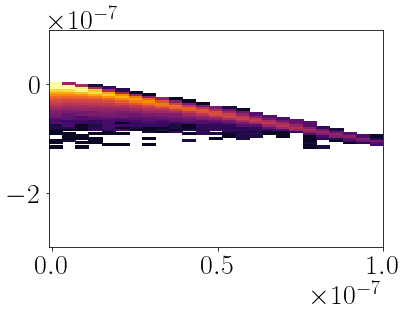

In [97]:
ind = np.argmin(np.abs(xedge))
plt.pcolor(xedge[ind:], xedge, np.log10(denominator[:,ind:]), vmin = -8, vmax=-2, cmap='inferno')

possum = denominator[:,ind+1:].sum()
negsum = denominator[:,0:ind+1].sum()

print(f'Ratio of pos/neg: {possum/negsum}')

In [148]:
(dsWC.EBFm.isel(ocean_time=30, eta_rho=YL).mean()*(1020*4000)/(2e-4*9.8)).values

array(10.24029677)

## RESPONSE TO REVIEWERS R1

A question is whether the surface velocity is correlated with the horizontal buoyancy gradients. This is normally assumed in the frontal dynamics literature, and of course won't be completely correct in the case of barotropic (relative to MLD) flows. However the surface fronts are often created from the barotropic strain field, again suggesting alignment. 

How do we check this? Some ideas:

    [] Could simply scatter u_o against grad b (by component or mag?) This would tell us whether there is alignment.
    [] Can I weight the above by EBF' or EBF (ie. where is the large EBF coming from in this parameter space?)
    [] Look at EBFp/EBFm as a function of u_o vs nabla b? Ie. where do the largest EBF' come from?
    

/tmp/ipykernel_95499/4139763468.py:25: RuntimeWarning: divide by zero encountered in log10
  ix = ax.pcolor(xedges, yedges, np.log10(denominator), vmin = -8, vmax=-2, cmap='inferno')


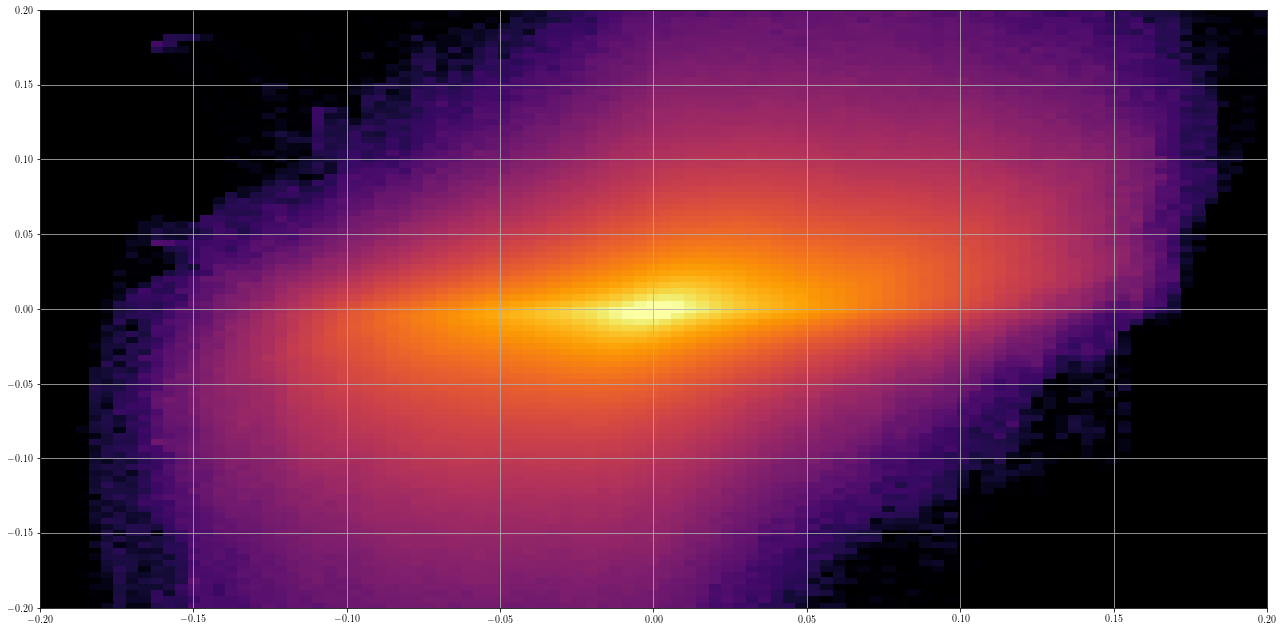

In [10]:
fig, axs = plt.subplots(1,1,figsize=(22, 11), sharey=False)
xedges = np.linspace(-0.2, 0.2, 100)
yedges = np.linspace(-0.2, 0.2, 100)

uo_scale = -dsWC.by/(dsWC.f**2)
uo_scale = -dsWC.hbl*dsWC.by/dsWC.f
uo = xroms.to_rho(dsWC.u.isel(s_rho=-1), gridWC)/7
vo_scale = dsWC.bx/(dsWC.f**2)/500
# vo_scale = dsWC.hbl*dsWC.bx/dsWC.f
vo = xroms.to_rho(dsWC.v.isel(s_rho=-1), gridWC)/7
#tau' vs tau'_theory
# histoPlot(vo.values.flatten(), vo_scale.values.flatten(), xedges, xedges, ax[0])
# ax[0].set_xlim(xedges[0], xedges[-1])
# ax[0].set_ylim(yedges[0], yedges[-1])
# ax[0].set_aspect('auto')

ax = axs
xvals = vo.values.flatten()
yvals = vo_scale.values.flatten()

# Make the plot
denominator, _, _ = np.histogram2d(xvals, yvals ,bins=(xedges, yedges), density=False)
denominator = denominator/np.sum(denominator)
denominator = denominator.T #need to transpose to have the correct orientation.
ix = ax.pcolor(xedges, yedges, np.log10(denominator), vmin = -8, vmax=-2, cmap='inferno')
ix.set_edgecolors('face')
# ax.plot(xedges, xedges, color='w')
ax.grid()
ax.set_facecolor('k')

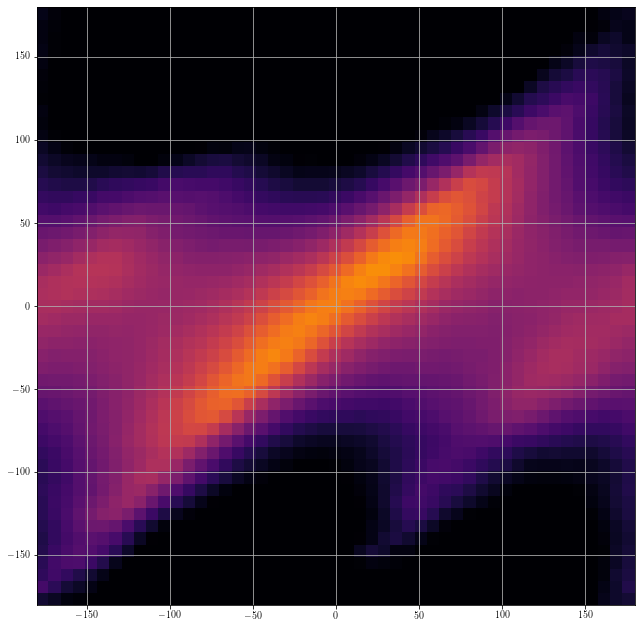

In [12]:
# This plots the angle of fronts relative to angle of surface currents. 
# Try conditional histogram on gradb
# Could also conditional average on velocity

frontangle = np.arctan2(dsWC.bx, -dsWC.by) # direction of thermal wind flow
currangle = np.arctan2(vo, uo)
# currangle = np.arctan2(dsWC.vg_o, dsWC.ug_o)

# Where there are fronts
currangle = currangle.where(dsWC.Nablab>dsWC.f**2, drop=True)
frontangle = frontangle.where(dsWC.Nablab>dsWC.f**2, drop=True)
yl = slice(900, 1100) #WZ
yl = slice(1900, 2100) #SZ
yl = YL
currangle = currangle.isel(eta_rho=yl)
frontangle = frontangle.isel(eta_rho=yl)
# Where there are currents
# frontangle = frontangle.where(dsWC.usurfmag>0.01, drop=True)
# currangle = currangle.where(dsWC.usurfmag>0.01, drop=True)

fig, axs = plt.subplots(1,1,figsize=(22, 11), sharey=False)
xedges = np.linspace(-np.pi, np.pi, 50)
yedges = xedges

ax = axs
xvals = frontangle.values.flatten()
yvals = currangle.values.flatten()

# Make the plot
denominator, _, _ = np.histogram2d(xvals, yvals ,bins=(xedges, yedges), density=False)
denominator = denominator/np.sum(denominator)
denominator = denominator.T #need to transpose to have the correct orientation.
ix = ax.pcolor(xedges*180/np.pi, yedges*180/np.pi, np.log10(denominator), vmin = -4, vmax=-2, cmap='inferno')
ix.set_edgecolors('face')
ax.axis('square')
# ax.plot(xedges, xedges, color='w')
ax.grid()
ax.set_facecolor('k')

# plt.savefig('usurf_vs_fronts.png')

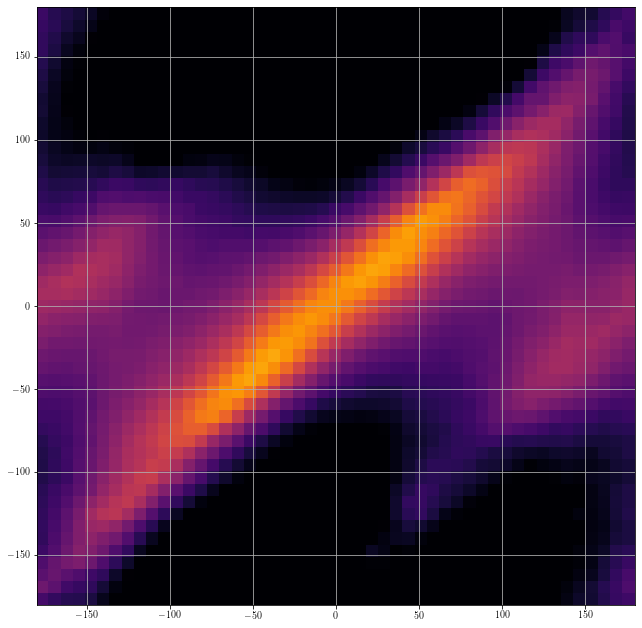

In [46]:
# This plots the angle of fronts relative to angle of surface currents. 
# Try conditional histogram on gradb
# Could also conditional average on velocity

frontangle = np.arctan2(dsWC.bx, -dsWC.by) # direction of thermal wind flow
currangle = np.arctan2(vo, uo)
# currangle = np.arctan2(dsWC.vg_o, dsWC.ug_o)

# Where there are fronts
currangle = currangle.where(dsWC.Nablab>dsWC.f**2, drop=True)
frontangle = frontangle.where(dsWC.Nablab>dsWC.f**2, drop=True)
yl = slice(900, 1100) #WZ
yl = slice(1900, 2100) #SZ
yl = YL
currangle = currangle.isel(eta_rho=yl)
frontangle = frontangle.isel(eta_rho=yl)
# Where there are currents
# frontangle = frontangle.where(dsWC.usurfmag>0.01, drop=True)
# currangle = currangle.where(dsWC.usurfmag>0.01, drop=True)

fig, axs = plt.subplots(1,1,figsize=(22, 11), sharey=False)
xedges = np.linspace(-np.pi, np.pi, 50)
yedges = xedges

ax = axs
xvals = frontangle.values.flatten()
yvals = currangle.values.flatten()

# Make the plot
denominator, _, _ = np.histogram2d(xvals, yvals ,bins=(xedges, yedges), density=False, weights=np.abs(dsWC.Nablab).isel(eta_rho=yl).values.flatten())
denominator = denominator/np.sum(denominator)
denominator = denominator.T #need to transpose to have the correct orientation.
ix = ax.pcolor(xedges*180/np.pi, yedges*180/np.pi, np.log10(denominator), vmin = -4, vmax=-2, cmap='inferno')
ix.set_edgecolors('face')
ax.axis('square')
# ax.plot(xedges, xedges, color='w')
ax.grid()
ax.set_facecolor('k')

# plt.savefig('usurf_vs_fronts.png')

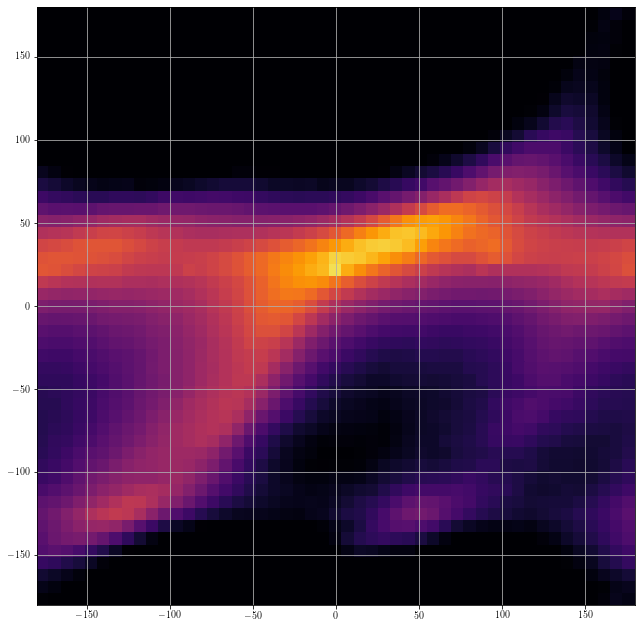

In [271]:
# This plots the angle of fronts relative to angle of surface currents. 
# Try conditional histogram on gradb
# Could also conditional average on velocity

frontangle = np.arctan2(dsWC.bx, -dsWC.by) # direction of thermal wind flow

currangle = np.arctan2(vo, uo)
currangle = np.arctan2(dsWC.vg_o, dsWC.ug_o)

stressangle = np.arctan2(xroms.to_rho(typ, gridWC), xroms.to_rho(txp, gridWC))

# Where there are fronts
currangle = currangle.isel(ocean_time=TR)
frontangle = frontangle.isel(ocean_time=TR)
currangle = currangle.where(dsWC.Nablab.isel(ocean_time=TR)>dsWC.f**2, drop=True)
frontangle = frontangle.where(dsWC.Nablab.isel(ocean_time=TR)>dsWC.f**2, drop=True)
stressangle = stressangle.where(dsWC.Nablab.isel(ocean_time=TR)>dsWC.f**2, drop=True)


# currangle = currangle.isel(eta_rho=YL)
# frontangle = frontangle.isel(eta_rho=YL)
# stressangle = 
# Where there are currents
# frontangle = frontangle.where(dsWC.usurfmag>0.01, drop=True)
# currangle = currangle.where(dsWC.usurfmag>0.01, drop=True)

fig, axs = plt.subplots(1,1,figsize=(22, 11), sharey=False)
xedges = np.linspace(-np.pi, np.pi, 50)
yedges = xedges

ax = axs
xvals = frontangle.values.flatten() 
# xvals = currangle.values.flatten() 
yvals = stressangle.values.flatten()
# Make the plot
denominator, _, _ = np.histogram2d(xvals, yvals ,bins=(xedges, yedges), density=False)
denominator = denominator/np.sum(denominator)
denominator = denominator.T #need to transpose to have the correct orientation.
denominator = np.roll(denominator, int(len(xedges)/2), axis=0)
ix = ax.pcolor(xedges*180/np.pi, yedges*180/np.pi, np.log10(denominator), vmin = -4, vmax=-2, cmap='inferno')
ix.set_edgecolors('face')
ax.axis('square')
# ax.plot(xedges, xedges, color='w')
ax.grid()
ax.set_facecolor('k')

plt.savefig('taup_vs_fronts.png')

In [269]:
# Make a plot that lays out the whole progression
# tau' to u_surf
# tau' to u_g_surf
# u_surf to fronts
# tau' to fronts

denominator.shape

(49, 49)

In [226]:
# frontangle = np.arctan2(dsWC.bx, -dsWC.by) # direction of thermal wind flow
# currangle = np.arctan2(vo, uo)
stressangle = np.arctan2(xroms.to_rho(typ, gridWC), xroms.to_rho(txp, gridWC))

# Where there are fronts
# currangle = currangle.where(dsWC.Nablab>dsWC.f**2, drop=True)
# frontangle = frontangle.where(dsWC.Nablab>dsWC.f**2, drop=True)
stressangle = stressangle.where(dsWC.Nablab.isel(ocean_time=TR)>dsWC.f**2, drop=True)

stressangle

<xarray.DataArray 'svstr' (ocean_time: 25, eta_rho: 3580, xi_rho: 1002)>
dask.array<where, shape=(25, 3580, 1002), dtype=float32, chunksize=(1, 3580, 1002), chunktype=numpy.ndarray>
Coordinates:
  * ocean_time  (ocean_time) float64 3.154e+07 3.162e+07 ... 3.352e+07 3.361e+07
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000 1001
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 ... 3996 3997 3998 3999 4000 4001
    x_rho       (eta_rho, xi_rho) float32 dask.array<chunksize=(3580, 1002), meta=np.ndarray>
    y_rho       (eta_rho, xi_rho) float32 dask.array<chunksize=(3580, 1002), meta=np.ndarray>
    time        (ocean_time) float64 3.154e+07 3.162e+07 ... 3.352e+07 3.361e+07

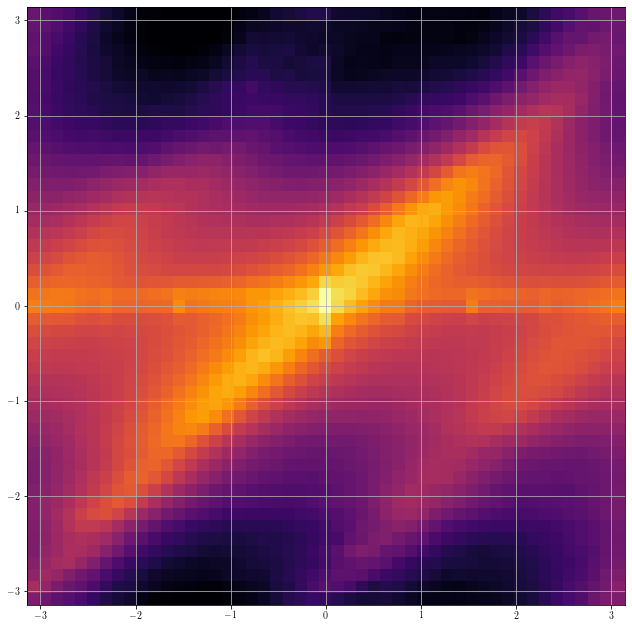

In [225]:
# This plots the angle of fronts relative to angle of surface currents. 
# Maybe some indication of a pattern, but it's hard to see.
# Looks pretty good when weighted by the strength of the fronts
# This means at strong fronts, the surface currents and fronts are in alignment.
# Brings it back to the question of is it the sharpest fronts that matter?

# Two ingredients for EBFp are frontal strength and u_o.

frontangle = np.arctan2(dsWC.bx, -dsWC.by)
currangle = np.arctan2(vo, uo)


fig, axs = plt.subplots(1,1,figsize=(22, 11), sharey=False)
xedges = np.linspace(-np.pi, np.pi, 50)
yedges = xedges

ax = axs
xvals = frontangle.values.flatten()
yvals = currangle.values.flatten()

# Make the plot
denominator, _, _ = np.histogram2d(xvals, yvals ,bins=(xedges, yedges), density=False, weights = dsWC.usurfmag.values.flatten())#dsWC.Nablab.values.flatten())
denominator = denominator/np.sum(denominator)
denominator = denominator.T #need to transpose to have the correct orientation.
ix = ax.pcolor(xedges, yedges, np.log10(denominator), vmin = -5, vmax=-2, cmap='inferno')
ix.set_edgecolors('face')
ax.axis('square')
# ax.plot(xedges, xedges, color='w')
ax.grid()
ax.set_facecolor('k')



/tmp/ipykernel_96507/3051715585.py:24: RuntimeWarning: divide by zero encountered in log10
  ix = ax.pcolor(xedges, yedges, np.log10(denominator), vmin = -6, vmax=-2, cmap='inferno')
/tmp/ipykernel_96507/3051715585.py:26: RuntimeWarning: divide by zero encountered in log10
  ix = ax.contour(xedges[1:], yedges[1:], np.log10(denominator), np.linspace(-6, -2, 5), colors='w')


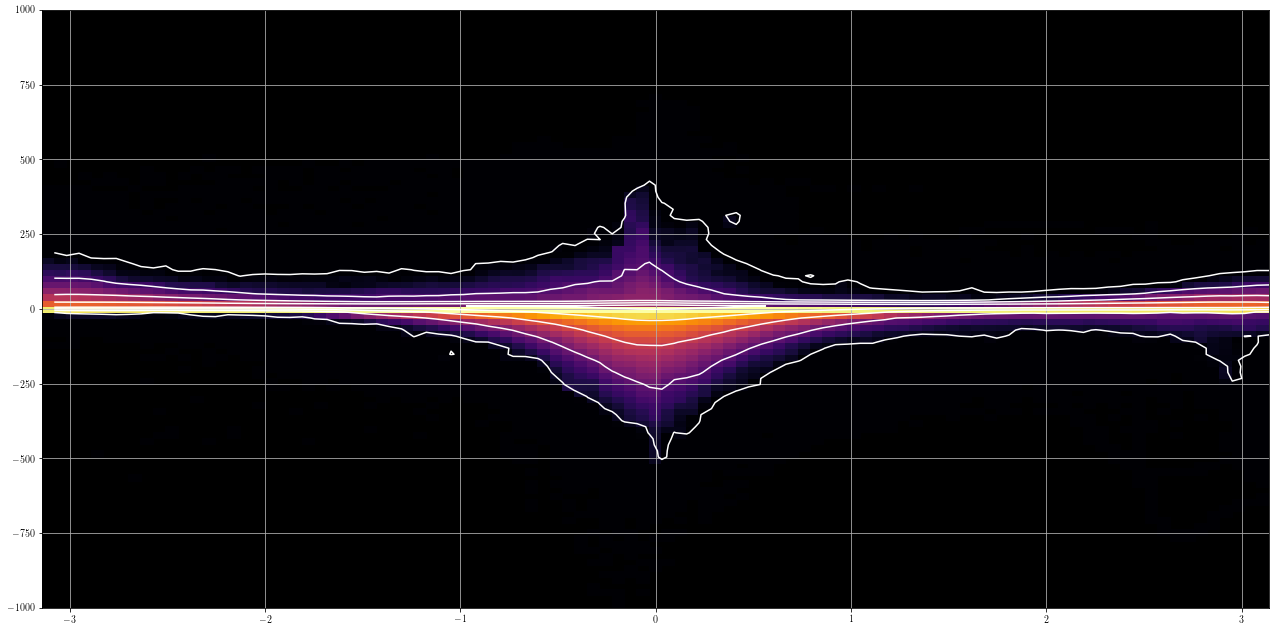

In [247]:
# Plotting front curr mismatch as a function of nabla b

frontangle = np.arctan2( dsWC.bx, -dsWC.by)
currangle = np.arctan2(vo, uo)
# currangle = np.arctan2(dsWC.vg_o, dsWC.ug_o)

fig, axs = plt.subplots(1,1,figsize=(22, 11), sharey=False)
xedges = np.linspace(-np.pi, np.pi, 100)
yedges = xedges
yedges = np.linspace(-1000, 1000, 100)

ax = axs
xvals = (frontangle-currangle).values.flatten()
# yvals = currangle.values.flatten()
yvals = (dsWC.Nablab/(dsWC.f**2)).values.flatten()
yvals = (dsWC.Nablab/dsWC.f**2).values.flatten()

yvals = (btowatts*dsWC.EBFp).values.flatten()

# Make the plot
denominator, _, _ = np.histogram2d(xvals, yvals ,bins=(xedges, yedges), density=False)
denominator = denominator/np.sum(denominator)
denominator = denominator.T #need to transpose to have the correct orientation.
ix = ax.pcolor(xedges, yedges, np.log10(denominator), vmin = -6, vmax=-2, cmap='inferno')
ix.set_edgecolors('face')
ix = ax.contour(xedges[1:], yedges[1:], np.log10(denominator), np.linspace(-6, -2, 5), colors='w')

# ax.axis('square')
# ax.plot(xedges, xedges, color='w')
ax.grid()
ax.set_facecolor('k')

/homes/metofac/wenegrat/.conda/envs/CFB_EBF_2/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/homes/metofac/wenegrat/.conda/envs/CFB_EBF_2/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tmp/ipykernel_96507/1413217322.py:30: RuntimeWarning: divide by zero encountered in log10
  ix = ax.pcolor(xedges, yedges, np.log10(denominator), vmin = -4, vmax=-2, cmap='inferno')


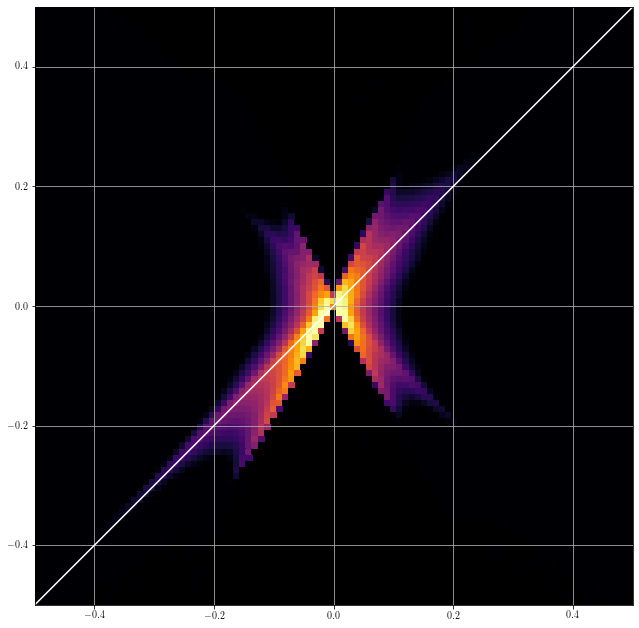

In [280]:
# Scatter EBFp/EBFm against EBFp (or u, nabla b)
# Goal is to see, when is EBFp 'big' (which could be in an absolute sense or?)
# This validates the ratio in the ms.

btowatts=(1020*4000)/(2e-4*9.8)

fig, axs = plt.subplots(1,1,figsize=(22, 11), sharey=False)
xedges = np.linspace(-0.5, 0.5, 100)
yedges = xedges

ax = axs
# filt = (btowatts*np.abs(dsWC.EBF)>1)
frontangle = np.arctan2(dsWC.bx, -dsWC.by) # direction of thermal wind flow
filt = (dsWC.Nablab > dsWC.f**2)
yvals = (dsWC.EBFp/(dsWC.EBFm)).where(filt, drop=True).values.flatten()
xvals = -(dsWC.usurfmag/(7*np.cos(frontangle-np.pi/4))).where(filt, drop=True).values.flatten() #note pi/4 factor is because of the wind direction

# xedges = np.linspace(-50, 50, 100)
# yedges = np.linspace(-10, 100, 100)

# xvals = btowatts*dsWC.EBFp.isel(ocean_time=TR).values.flatten()
# yvals = (dsWC.Nablab/dsWC.f**2).values.flatten()
# yedges = np.linspace(0, 0.1, 100)
# yvals = (np.sqrt(xroms.to_rho((txp - txptheory)**2, gridWC) + xroms.to_rho((typ-typtheory)**2, gridWC))/(1e-3*7**2)).values.flatten()

# Make the plot
denominator, _, _ = np.histogram2d(xvals, yvals ,bins=(xedges, yedges), density=False)
denominator = denominator/np.sum(denominator)
denominator = denominator.T #need to transpose to have the correct orientation.
ix = ax.pcolor(xedges, yedges, np.log10(denominator), vmin = -4, vmax=-2, cmap='inferno')
ix.set_edgecolors('face')
ax.axis('square')
ax.plot(xedges, xedges, color='w')
ax.grid()
ax.set_facecolor('k')


/tmp/ipykernel_95499/2811382370.py:29: RuntimeWarning: divide by zero encountered in log10
  ix = ax.pcolor(xedges, yedges, np.log10(denominator), vmin = -5, vmax=-2, cmap='inferno')


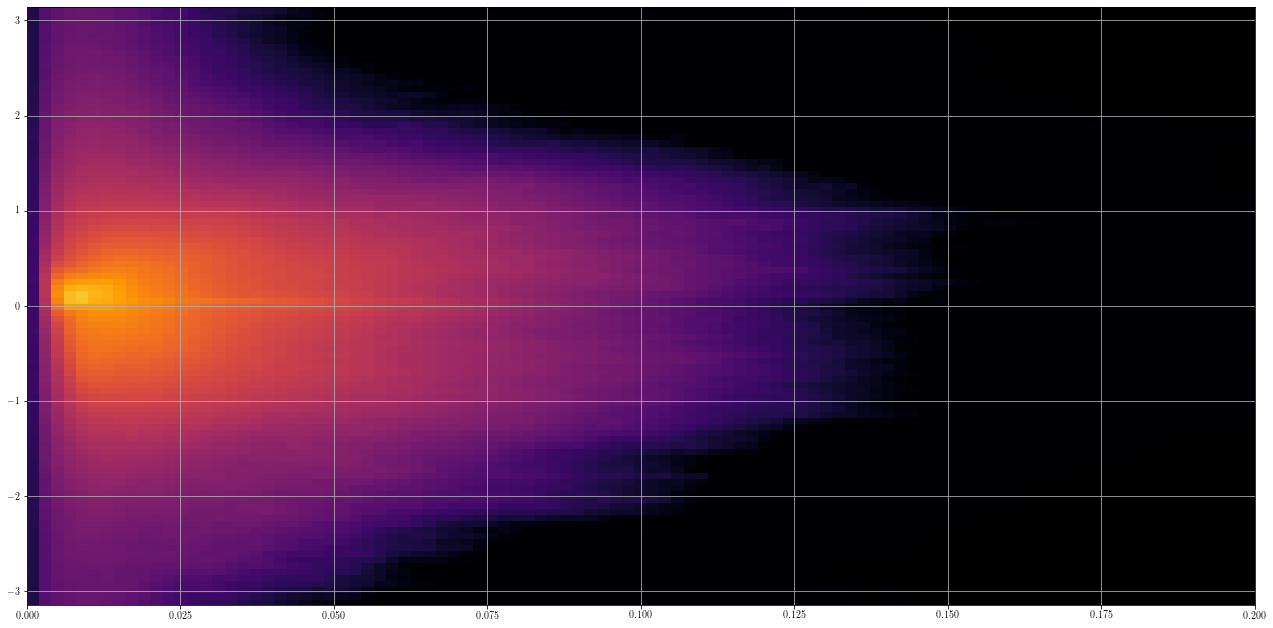

In [88]:
# Scatter Current magnitude as a function of current direction
# Goal is to see if the pattern of antifrontal flow can be explained by which direction the currents are strong


fig, axs = plt.subplots(1,1,figsize=(22, 11), sharey=False)
xedges = np.linspace(0, 0.2, 100)
yedges = np.linspace(-np.pi, np.pi, 100)

ax = axs
# filt = (btowatts*np.abs(dsWC.EBF)>1)
currangle = np.arctan2(vo, uo)

filt = (dsWC.Nablab > dsWC.f**2)
yvals = currangle.where(filt, drop=True).values.flatten()
xvals = dsWC.usurfmag.where(filt, drop=True).values.flatten()/7 #note pi/4 factor is because of the wind direction

# xedges = np.linspace(-50, 50, 100)
# yedges = np.linspace(-10, 100, 100)

# xvals = btowatts*dsWC.EBFp.isel(ocean_time=TR).values.flatten()
# yvals = (dsWC.Nablab/dsWC.f**2).values.flatten()
# yedges = np.linspace(0, 0.1, 100)
# yvals = (np.sqrt(xroms.to_rho((txp - txptheory)**2, gridWC) + xroms.to_rho((typ-typtheory)**2, gridWC))/(1e-3*7**2)).values.flatten()

# Make the plot
denominator, _, _ = np.histogram2d(xvals, yvals ,bins=(xedges, yedges), density=False)
denominator = denominator/np.sum(denominator)
denominator = denominator.T #need to transpose to have the correct orientation.
ix = ax.pcolor(xedges, yedges, np.log10(denominator), vmin = -5, vmax=-2, cmap='inferno')
ix.set_edgecolors('face')
# ax.axis('square')
# ax.plot(xedges, xedges, color='w')
ax.grid()
ax.set_facecolor('k')


In [203]:
txp

<xarray.DataArray 'sustr' (ocean_time: 25, eta_rho: 4002, xi_u: 1001)>
dask.array<sub, shape=(25, 4002, 1001), dtype=float32, chunksize=(1, 4002, 1001), chunktype=numpy.ndarray>
Coordinates:
  * xi_u        (xi_u) int64 0 1 2 3 4 5 6 7 ... 994 995 996 997 998 999 1000
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 ... 3996 3997 3998 3999 4000 4001
  * ocean_time  (ocean_time) float64 3.154e+07 3.162e+07 ... 3.352e+07 3.361e+07
    time        (ocean_time) float64 3.154e+07 3.162e+07 ... 3.352e+07 3.361e+07
Attributes:
    long_name:      Kinematic u wind stress component
    units:          N/m2
    standard_name:  surface_downward_eastward_stress
    grid:           <xgcm.Grid>\nX Axis (not periodic, boundary=None):\n  * c...

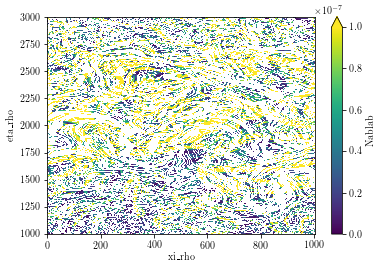

In [153]:
dsWC.Nablab.isel( ocean_time=0).where(np.abs((frontangle-currangle).isel(ocean_time=-1))>90*np.pi/180).plot(vmin=0, vmax=10*1e-8)

Text(0, 0.5, 'y [index]')

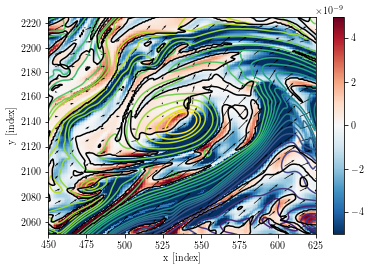

In [93]:
frontangle = np.arctan2(dsWC.bx, -dsWC.by) # direction of thermal wind flow
um = uo.mean('xi_rho')
currangle = np.arctan2(vo, uo)
filt = (dsWC.Nablab > 0*dsWC.f**2)
vals = np.abs((frontangle-currangle)*180/np.pi).where(filt).isel(ocean_time=-1)
# plt.pcolor(dsWC.xi_rho, dsWC.eta_rho, vals, cmap='twilight_shifted')
plt.pcolor(dsWC.xi_rho, dsWC.eta_rho, dsWC.EBFp.isel(ocean_time=-1), cmap='RdBu_r', vmin=-5e-9, vmax=5e-9)
plt.colorbar()
# vals.plot(cmap='hsv')
plt.contour(dsWC.xi_rho, dsWC.eta_rho, dsWC.rho.isel(s_rho=-1, ocean_time=-1), np.linspace(25.1, 25.7, 20))
# plt.contour(dsWC.EBFp.isel(ocean_time=-1), [0, 10])
plt.contour(dsWC.xi_rho, dsWC.eta_rho, vals, [90, 270], colors='k')
# dss = dsWC.resample
plt.quiver(dss.xi_rho, dss.eta_rho, dss.uo.isel(ocean_time=-1), dss.vo.isel(ocean_time=-1), scale=10)
plt.ylim(2050, 2225)
plt.xlim(450, 625)
plt.xlabel('x [index]')
plt.ylabel('y [index]')
# plt.savefig('front_angle.png')

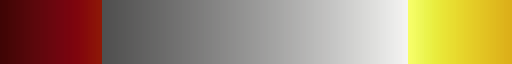

In [84]:
cmo.oxy

(400.0, 600.0)

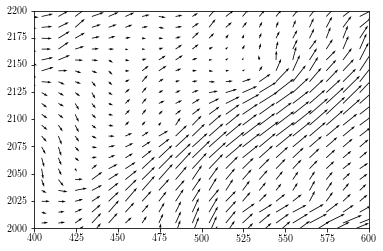

In [42]:
plt.quiver(dss.xi_rho, dss.eta_rho, dss.uo.isel(ocean_time=-1), dss.vo.isel(ocean_time=-1), scale=10)
plt.ylim(2000, 2200)
plt.xlim(400, 600)

In [ ]:
dss = dsWC.coarsen(eta_rho=10, boundary='trim').mean().coarsen(xi_rho=10, boundary='trim').mean()

/tmp/ipykernel_96507/643734385.py:5: UserWarning: No contour levels were found within the data range.
  plt.contour(vals, [-90, 270], colors='k')


(400.0, 600.0)

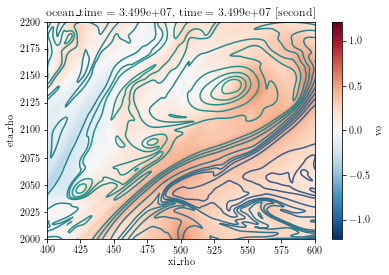

In [307]:

vals = dsWC.vo.isel(ocean_time=-1)
vals.plot()
plt.contour(dsWC.rho.isel(s_rho=-1, ocean_time=-1), 50)
# plt.contour(dsWC.EBFp.isel(ocean_time=-1), [0, 10])
plt.contour(vals, [-90, 270], colors='k')
# plt.quiver(dsWC.uo.isel(ocean_time=-1), dsWC.vo.isel(ocean_time=-1))
plt.ylim(2000, 2200)
plt.xlim(400, 600)

In [ ]:
dsWC.u.where(dsWC.z_rho_u>-xroms.to_u(dsWC.hbl, gridWC), drop=True)

/homes/metofac/wenegrat/.conda/envs/CFB_EBF_2/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6643: RuntimeWarning: invalid value encountered in divide
  tops = (tops / np.diff(bins)) / tops[-1].sum()


0.24063239
1.3971918e-07


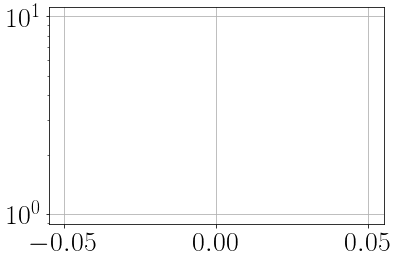

In [207]:
btowatts=(1020*4000)/(2e-4*9.8)

#what's the distribution of the ratio?
def histplot(var, bins, weights=None):
    varf = var.where(np.isfinite(var), drop=True) #drop infinite values or NaN
    varf = varf.values.flatten()
    plt.hist(varf, bins, weights=weights, density=True, stacked=True)
#     vmean = np.nanmedian(varf)
#     plt.axvline(vmean, color='k')
    plt.ylabel('Counts')
    plt.xlabel('$|\boldsymbol{u_o}|/|\boldsymbol{U_a}|$')
    plt.grid()
    
ratio = dsWC.usurfmag/(7)

# ratio = dsWC.EBFp/np.abs(dsWC.EBFm)
histplot(ratio, np.linspace(0.2, 0.2))


# ratio = ratio.where(dsWC.Nablab>dsWC.f**2, drop=True)
# plt.hist(ratio.values.flatten(), np.linspace(-0.5, 0.5, 40), 100);
print(np.nanmax(ratio.where(np.isfinite(ratio))))
print(np.nanmin(ratio.where(np.isfinite(ratio))))
# print(np.nanmean(ratio.flatten()[np.isfinite(ratio.flatten)]))
plt.yscale('log')

max: 0.24063238501548767
min: 1.3971917667277012e-07


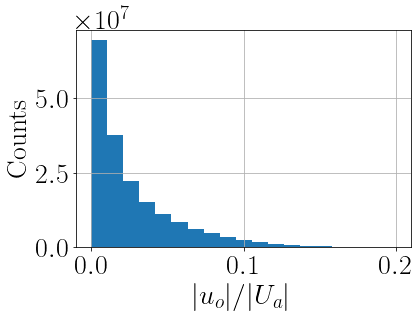

In [215]:
# Velocity plot for the reviewer #2
var = (dsWC.usurfmag/(7))
varf = var.where(np.isfinite(var), drop=True) #drop infinite values or NaN
varf = varf.values.flatten()
plt.hist(varf, np.linspace(-0, 0.2, 20), density=False)
plt.ylabel('Counts')
plt.xlabel('$|{u_o}|/|{U_a}|$')
plt.grid()

plt.savefig('velhisto.pdf', bbox_inches='tight')
    
print(f'max: {np.nanmax(ratio)}')
print(f'min: {np.nanmin(ratio)}')

In [216]:
0.25*7

1.75

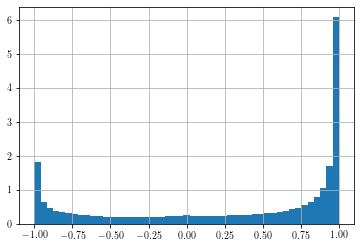

In [159]:
ratio = np.cos(frontangle-currangle)
histplot(ratio, np.linspace(-1, 1, 50))

In [189]:
def multiple_formatter(denominator=2, number=np.pi, latex='\pi'):
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    def _multiple_formatter(x, pos):
        den = denominator
        num = np.int(np.rint(den*x/number))
        com = gcd(num,den)
        (num,den) = (int(num/com),int(den/com))
        if den==1:
            if num==0:
                return r'$0$'
            if num==1:
                return r'$%s$'%latex
            elif num==-1:
                return r'$-%s$'%latex
            else:
                return r'$%s%s$'%(num,latex)
        else:
            if num==1:
                return r'$\frac{%s}{%s}$'%(latex,den)
            elif num==-1:
                return r'$\frac{-%s}{%s}$'%(latex,den)
            else:
                return r'$\frac{%s%s}{%s}$'%(num,latex,den)
    return _multiple_formatter

/tmp/ipykernel_95499/1691380931.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num = np.int(np.rint(den*x/number))
/tmp/ipykernel_95499/1691380931.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20

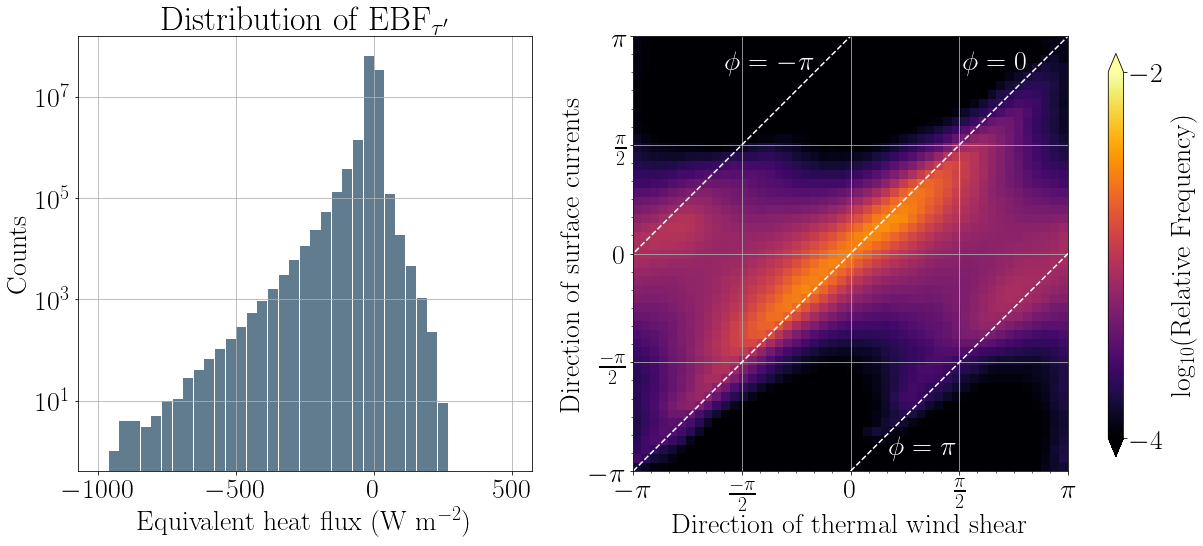

In [220]:
fig, ax = plt.subplots(1,2,figsize=(16*1/0.95, 8))

# Plot the EBF' distribution
##############################
varf = btowatts*dsWC.EBFp.isel(ocean_time=slice(5, 30))
ax[0].hist(varf.values.flatten(), np.linspace(-1000, 500, 40), color='#607c8e', rwidth=0.95)
ax[0].set_yscale('log')
ax[0].grid()
ax[0].set_title('Distribution of $\mathrm{EBF_{\\tau^\prime}}$')
ax[0].set_ylabel('Counts')
ax[0].set_xlabel('Equivalent heat flux (W m$^{-2}$)')
# Plot the joint pdf of angles
##############################
frontangle = np.arctan2(dsWC.bx, -dsWC.by) # direction of thermal wind flow
currangle = np.arctan2(vo, uo)

# Where there are fronts
currangle = currangle.where(dsWC.Nablab>dsWC.f**2, drop=True)
frontangle = frontangle.where(dsWC.Nablab>dsWC.f**2, drop=True)
yl = slice(900, 1100) #WZ
yl = slice(1900, 2100) #SZ
yl = YL
currangle = currangle.isel(eta_rho=yl)
frontangle = frontangle.isel(eta_rho=yl)

xedges = np.linspace(-np.pi, np.pi, 50)
yedges = xedges

xvals = frontangle.values.flatten()
yvals = currangle.values.flatten()

# Make the plot
denominator, _, _ = np.histogram2d(xvals, yvals ,bins=(xedges, yedges), density=False)
denominator = denominator/np.sum(denominator)
denominator = denominator.T #need to transpose to have the correct orientation.
ix = ax[1].pcolor(xedges, yedges, np.log10(denominator), vmin = -4, vmax=-2, cmap='inferno')
ix.set_edgecolors('face')
ax[1].axis('square')
# ax.plot(xedges, xedges, color='w')
ax[1].grid()
ax[1].set_facecolor('k')
ax[1].plot(xedges, xedges, color='w', linestyle='--')
ax[1].plot(xedges-np.pi, xedges, color='w', linestyle='--')
ax[1].plot(xedges+np.pi, xedges, color='w', linestyle='--')
ax[1].set_xlim(xedges[0], xedges[-1])
ax[1].set_ylim(yedges[0], yedges[-1])
ax[1].set_xlabel('Direction of thermal wind shear')
ax[1].set_ylabel('Direction of surface currents')
# ax[1].annotate('$\phi=-\pi$',(0.3, 0.8), xycoords ='axes fraction', text)
ax[1].text(-1.82, 2.65, '$\phi=-\pi$', color='w')
ax[1].text(0.55, -2.9, '$\phi=\pi$', color='w')
ax[1].text(1.62, 2.65, '$\phi=0$', color='w')

ax[1].xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax[1].xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
ax[1].xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
ax[1].yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax[1].yaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
ax[1].yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))

# ax[1].xaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
# ax[1].xaxis.set_major_locator(tck.MultipleLocator(base=1.0))
# Add Colorbar
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.975, 0.15, 0.0125, 0.7])
cb = fig.colorbar(ix, cax=cbar_ax, extend='both')
cb.set_label('log$_{10}$(Relative Frequency)')
cb.set_ticks([-4, -2])
cb.solids.set_edgecolor("face") 

plt.savefig('EBFhistogram.pdf', bbox_inches='tight')


In [103]:
# Histogram plot with:
# 1) u/U
# 2) angcurr vs. angfront
# 2) EBF'/|EBFm|


In [81]:
print(np.nanmean(ratio.where(np.isfinite(ratio), drop=True)))

/homes/metofac/wenegrat/.conda/envs/CFB_EBF_2/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/homes/metofac/wenegrat/.conda/envs/CFB_EBF_2/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


173.40056


In [79]:
print(np.nanmean(ratio.flatten()[np.isfinite(ratio.flatten)]))

AttributeError: 'DataArray' object has no attribute 'flatten'

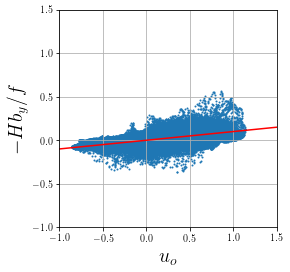

In [25]:
# Check u_o ~ H grad b/f scaling
grid = gridWC
ts = -1
uo_scale = -dsWC.hbl*dsWC.by/dsWC.f
uo = xroms.to_rho(dsWC.u.isel(s_rho=-1), grid)

plt.scatter(uo.isel(ocean_time=ts), uo_scale.isel(ocean_time=ts), s=1)
plt.plot(np.linspace(-2, 2), 1e-1*np.linspace(-2,2), color='r')
plt.grid()
plt.xlim(-1, 1.5)
plt.ylim(-1, 1.5)

plt.xlabel('$u_o$', fontsize=20)
plt.ylabel('$-H b_y/f$', fontsize=20)

plt.axis('square')
plt.xlim(-1, 1.5)
plt.ylim(-1, 1.5)

#plt.savefig('../figures/CheckGeoScaling.png')

In [131]:
dsWC.dz0.isel(s_rho=-1).mean().values

array(3.6290262, dtype=float32)

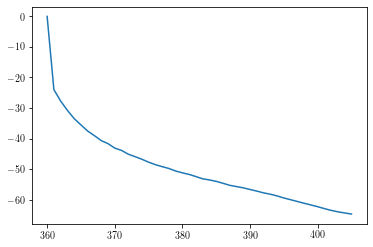

In [49]:
plt.plot(dsWC.ocean_time/86400, -dsWC.hbl.mean(('eta_rho', 'xi_rho')))